# Timeseries Analysis with Pandas - pd.Grouper 

I have been doing time series analysis for some time in python. The `pd.Grouper` class used in unison with the groupy calls are extremely powerful and flexible. Understanding the framework of how to use it is easy, and once those hurdles are defined it is straight forward to use effectively.

I began to look into alternatives to excel (my companies standard), when I started to max out the limitations of excel:
- limit the number of entries 
- calculation spread out over multiple sheets/workbooks
- error prone copying of data down columns

Then I found pandas. Pandas was a great all around tool for analysis, especially for people familiar with excel. But what really makes pandas shine is the incorporation of datatime objects, and the tools that can be uses to group and aggregate them. As always we start importing the primary tools:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Making the Pandas Dataframe time aware
The first thing that is required is to import our data, in this case it is 1-minute A-weighted sound levels from a long term noise monitor I have used in the past.

In [2]:
df = pd.read_csv('test_data_noise.csv')

In [3]:
df.head()

,Date (MDT),LAEQ
0,2020-04-08 14:08:00,60.9
1,2020-04-08 14:09:00,59.1
2,2020-04-08 14:10:00,58.7
3,2020-04-08 14:11:00,94.0
4,2020-04-08 14:12:00,94.0


Importing this way does a few things. The first is that a index is set for the dataset, 

My preference is to set the index to a [datetimeindex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html), or to have the index be a datetime. The new version of pandas at the time of this writing states that the datetime index is:
> Immutable ndarray of datetime64 data, represented internally as int64, and which can be boxed to Timestamp objects that are subclasses of datetime and carry metadata such as frequency information.

The are a couple of methods to do this: the first is defining the datetime index when importing the data, and the second is to import as normal and convert the timestamp data into a datetime index. 

### Converting a dataseries to a datetimeindex:
This is done simply by using the pandas method for converting a column to a datetime, aptly named [pandas.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html). The index for the dataframe can be directly called and set to the new datetime series:

In [4]:
df.index = pd.to_datetime(df['Date (MDT)'])
df.head()

,Date (MDT),LAEQ
Date (MDT),,
2020-04-08 14:08:00,2020-04-08 14:08:00,60.9
2020-04-08 14:09:00,2020-04-08 14:09:00,59.1
2020-04-08 14:10:00,2020-04-08 14:10:00,58.7
2020-04-08 14:11:00,2020-04-08 14:11:00,94.0
2020-04-08 14:12:00,2020-04-08 14:12:00,94.0


Note how the Jupyter renders the index name for the index. We now have a datetime aware index of our data. We can inspect the data type further by calling the index and looking at the results. We also need to drop the previous datetime data.

In [5]:
df = df.drop('Date (MDT)', axis = 1)

In [6]:
df.index

DatetimeIndex(['2020-04-08 14:08:00', '2020-04-08 14:09:00',
               '2020-04-08 14:10:00', '2020-04-08 14:11:00',
               '2020-04-08 14:12:00', '2020-04-08 14:13:00',
               '2020-04-08 14:14:00', '2020-04-08 14:14:01',
               '2020-04-08 14:15:00', '2020-04-08 14:16:00',
               ...
               '2020-04-11 07:32:00', '2020-04-11 07:33:00',
               '2020-04-11 07:34:00', '2020-04-11 07:35:00',
               '2020-04-11 07:36:00', '2020-04-11 07:37:00',
               '2020-04-11 07:38:00', '2020-04-11 07:39:00',
               '2020-04-11 07:40:00', '2020-04-11 07:41:00'],
              dtype='datetime64[ns]', name='Date (MDT)', length=4137, freq=None)

### Importing data setting a datetime index: 
This is the method that I usually use, as it sets everything from the start. It uses some of the additional parameters passed in the `pandas.read_csv` method (or any of the other methods). Looking at the input parameters, by setting two of them when can create a 

- `index_col`: the column we want to become the index
- `parse_dates` : the column we want to pass through a date parsing function

In [7]:
df = pd.read_csv('test_data_noise.csv', index_col=0, parse_dates=[0])

In [8]:
df.head()

,LAEQ
Date (MDT),
2020-04-08 14:08:00,60.9
2020-04-08 14:09:00,59.1
2020-04-08 14:10:00,58.7
2020-04-08 14:11:00,94.0
2020-04-08 14:12:00,94.0


## Using a time aware dataframe: Indexing and Slicing

The next step i typically do is to review and filter my data. In the environmental acoustic world this typically means removing calibration signals, invalid data (capturing noises in close proximity to the microphone), and marking certain times when an activity of interest is captured.

I generally spit out my data to a interactive plot making the review easier. In this case I have embedded a bokeh plot. This is done through rendering to HTML, and displaying via the Ipython.display HTML method.


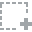
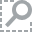
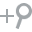
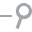
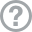
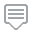
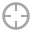
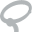
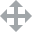
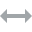
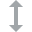
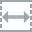
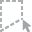
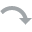
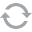
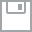
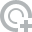
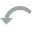
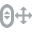
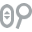
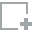
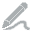
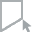
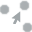
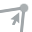

In [9]:
from bokeh.plotting import figure
from bokeh.resources import CDN, INLINE
from bokeh.embed import file_html

from IPython.display import HTML
# create a new plot with a title and axis labels

p = figure(title="Interactive Review Plot",
           x_axis_label='Timestamp',
           y_axis_label='Sound Level (dBA)',
           plot_width=900,
           plot_height=500,
           x_axis_type="datetime")

# add a line renderer with legend and line thickness
p.step(df.index, df['LAEQ'], legend_label="LAeq", line_width=2)
HTML(file_html(p, INLINE))

With the interactive plot the data can be reviewed. To keep track of what the data is I create two new columns in my data frame; `Exclude` and `Reason`. I set the entire `Exclude` column initially to `False` and the `Reason` to NaN. As I identify the times of interest or times that need exclusion, I can slice those time and set the columns.

The new columns are set using:

In [10]:
df['Exclude'] = False
df['Reason'] = np.nan

A quick example of doing this is excluding the calibration that occurs at the beginning of the record, which has a very distinct level of 94 dB. To mark this as an exclusion and to note a reason, the pandas `.loc` method can be used. The loc method takes two parameters, the rows and the columns you want to set. In this case I provide a a range of dates and the columns and the values to set them to.

In [11]:
df.loc['2020-04-08 14:10' : '2020-04-08 14:17', ['Exclude','Reason']] = [True, 'Calibration']
df.head(13)

,LAEQ,Exclude,Reason
Date (MDT),,,
2020-04-08 14:08:00,60.9,False,NaN
2020-04-08 14:09:00,59.1,False,NaN
2020-04-08 14:10:00,58.7,True,Calibration
2020-04-08 14:11:00,94.0,True,Calibration
2020-04-08 14:12:00,94.0,True,Calibration
2020-04-08 14:13:00,94.0,True,Calibration
2020-04-08 14:14:00,94.0,True,Calibration
2020-04-08 14:14:01,94.0,True,Calibration
2020-04-08 14:15:00,94.0,True,Calibration


The data is now marked as excluded and gives a reason. This can be used as a filter mask later on for analysis. Typically I would have additional metrics that could be used for tagging and exclusions, such as weather data or some other measurement. Below I show two more additional exclusions:

In [12]:
df.loc['2020-04-09 06:00' : '2020-04-09 09:00', ['Exclude','Reason']] = [True, 'Precipitation']
df.loc['2020-04-10 12:30' : '2020-04-10 13:45', ['Exclude','Reason']] = [True, 'Resident Acivity']

## Using pd.Grouper for Analysis

Pandas provides a class called [pd.Grouper](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html), which can be used with great success in time series analysis. I first started using it when it was called pd.TimeGrouper (now deprecated), which seemed a little more appropriate name for time series analysis. `pd.Grouper` has a parameter `freq` which can be used to quickly do meaningful time based analysis and reductions in data. Once data has been grouped, the groups can be passed to aggregate functions.

The first step is to create a valid data dataframe by using the `Exclude` mask to remove the data points marked for exclusion. This is easily done by applying the inverse of the `Exclude` series: 

In [13]:
df_valid = df[~df['Exclude']]

A typical analysis is to look at data on an hourly basis. to do this the dataframe is given the `groupby` method, and the

In [14]:
# group by 10 minute intervals
min_10_grouper = pd.Grouper(freq='10min')

# group the dataframe by "LAEQ" and use the 10 min intervals
min_10_groups = df_valid['LAEQ'].groupby(min_10_grouper)

#inspect the Groups
min_10_groups

Methods can now be passed to the groups to get meaningful data out. For example if I wanted the maximum sound level that occurred in each 10-min interval and quickly plotted. Notice the gaps in the data from the applied exclusions.

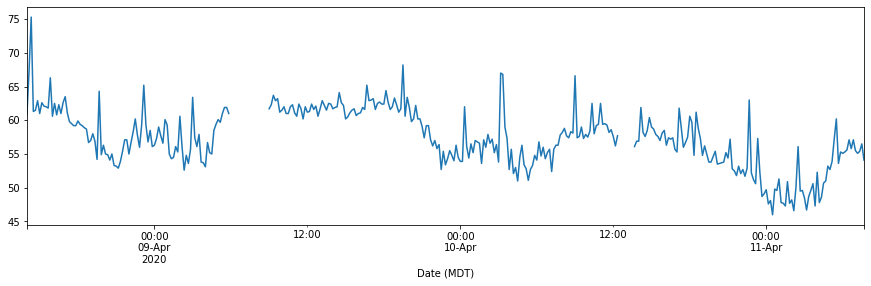

In [15]:
min_10_groups.max().plot(figsize=(15,4))

Lets say I want the hourly minimum sound level in a single line of code:

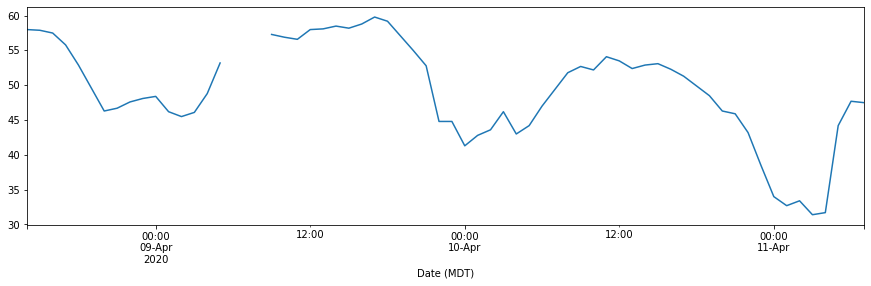

In [16]:
houly_average = df_valid['LAEQ'].groupby(pd.Grouper(freq='1h')).min()
houly_average.plot(figsize=(15,4))

It is also trivial to apply a function to the groups. For sound levels, the average time weighted sound level is calculated using a log base 10 average. This can be easily defined in a function and applied to the groups to return the average:


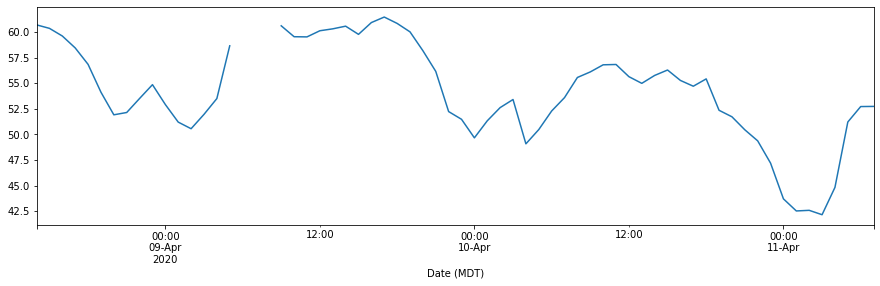

In [17]:
def time_weighted_average(series):
    twa = 10*np.log10((10**(series/10).mean()))
    return twa

hourly_groups = df_valid['LAEQ'].groupby(pd.Grouper(freq='1h'))
hourly_groups.apply(time_weighted_average).plot(figsize=(15,4))

pd.Grouper has many additional parameters for timeseries grouping. The one i use most often is the base parameter, in which you can define when a grouping starts. A good example of this is grouping by day, but where the start of the day isn't midnight.

In my province, the noise regulations for daytime and nighttime are:
- daytime hours: 07:00 - 22:00
- nighttime hours: 22:00 - 07:00

This technically makes a day start at 7 am. Doing groupby operations while applying this convention is easy using pd.Grouper. This is done by changing the frequency to 24 Hours (IE a day) and then setting the base hour as 7 (7 am). The results can be easily plotted to show the effects:

Date (MDT)
2020-04-08 07:00:00    AxesSubplot(0.125,0.2;0.775x0.68)
2020-04-09 07:00:00    AxesSubplot(0.125,0.2;0.775x0.68)
2020-04-10 07:00:00    AxesSubplot(0.125,0.2;0.775x0.68)
2020-04-11 07:00:00    AxesSubplot(0.125,0.2;0.775x0.68)
Freq: 24H, Name: LAEQ, dtype: object

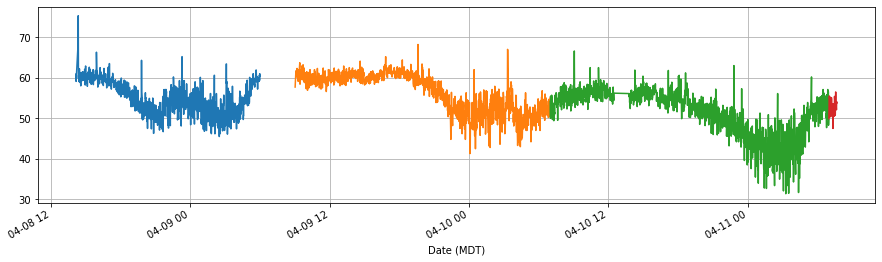

In [18]:
day_grouper = pd.Grouper(freq='24H', base = 7)
day_groups = df_valid['LAEQ'].groupby(day_grouper)
day_groups.plot(figsize=(15,4), grid=True)

You can see now that the days at seperated into days starting at 7 am. Day and night levels can be extracted using the `between_time` function and using the timeweighted average in a custom function:

In [19]:
def day_night(series):
    d = []
    day_hours = series.between_time(start_time='07:00', end_time='22:00',include_start=True, include_end=False)
    day_level = time_weighted_average(day_hours)
    night_hours = series.between_time(start_time='22:00', end_time='07:00',include_start=True, include_end=False)
    night_level = time_weighted_average(night_hours)
    d.append(day_level)
    d.append(night_level)
    return pd.DataFrame(d, index=['day', 'night'], columns=['LAEQ'])

In [20]:
day_groups.apply(day_night).unstack(level=1)

LAEQ           
                           day      night
Date (MDT)                               
2020-04-08 07:00:00  56.585793  53.413198
2020-04-09 07:00:00  59.878562  51.405926
2020-04-10 07:00:00  54.740655  46.252037
2020-04-11 07:00:00  52.747619        NaN

Timeseries analysis becomes much easier and less cumbersome when using Pandas. By making the index a datetimeindex, the data becomes time aware making standard and non standard tasks quiet trivial, and one can easily:
- aggregate date by time groupings
- apply simple data processing functions
- write custom functions for more detailed analysis 
- slice and filter through the data using datetime calls

